In [1]:
import os
import re
import nltk
from pprint import pprint
from pathlib import Path
import numpy as np

import pandas as pd
from pprint import pprint

#by this option we disable the possibility of a bad dataframe representation
pd.set_option('display.expand_frame_repr', False)

In [2]:
class SGDParser:
    
    #constructor class
    def __init__(self):
        pass
    
    #parse all the txt files - static function
    @staticmethod
    def get_sdg_files():
        return list(Path('sdg').glob('**/*.txt'))
    
    
    #reads the file and insert its lines into a list
    @staticmethod
    def get_lines(fname: Path):
        """

        :param fname:
        :return:
        """
        with open(fname, 'r', encoding='utf-8-sig') as infile:
            lines = list(map(str.strip, infile.readlines()))

        return lines
    
    #extracts the sdg by splitting the path in string, insert the strings in the list and get the second last string 
    #which is the information about the sdg
    @staticmethod
    def extract_sdg(fpath):
        """

        :param fpath:
        :return:
        """
        return str(fpath).split(os.sep)[-2]
    
    #function that returns keywords related with the abstract
    @property
    def keywords(self):
        """

        :return:
        """
        return sorted(
            set(map(str.lower, ['abstarct', 'abstract', 'abstratc', 'aim',
                                'background', 'introduction', 'objective',
                                'purpose']
                    )
                )
        )
    
    #function used to lowercase the words in the txt lines
    @staticmethod
    def lines_2_lowercase(lines):
        """

        :param lines:
        :return:
        """
        return list(map(str.lower, lines))
    
    #function to remove the 'Title:' in the txt files
    @staticmethod
    def remove_title_prefix(title):
        """

        :param title:
        :return:
        """
        if title and title.startswith('Title:'):
            return re.sub('Title:', '', title).strip()

        return title
    
    #function to join the title in case of more than 1 lines and to join the abstract lines into one by searching keywords
    def search_with_keyword(self, term, lowered_lines, lines, index):
        """

        :param term:
        :param lowered_lines:
        :param lines:
        :param index:
        :return:
        """
        doc = dict()
        matched = False

        if lowered_lines[index].startswith(term):
            doc['extracted_title'] = self.join_lines(lines[:index])
            doc['extracted_abstract'] = self.join_lines(lines[index:])
            doc['extracted'] = True
            matched = True

        return doc, matched
    
    #function to separate each line with ||
    @staticmethod
    def join_lines(lines):
        return ' || '.join(lines)

    #function to join the title in case of more than 1 lines and to join the abstract lines into one by searching in lines
    def search_in_lines(self, lowered_lines, lines, index):
        """

        :param lowered_lines:
        :param lines:
        :param index:
        :return:
        """
        doc = dict()
        matched = False

        for word in self.keywords:
            if lowered_lines[index].startswith(word):
                doc['extracted_title'] = self.join_lines(lines[:index])
                doc['extracted_abstract'] = self.join_lines(lines[index:])
                doc['extracted'] = True
                matched = True
                break

        return doc, matched

    #main function of the class - create the dataset by using the above functions
    def create_sdg_dataset(self):
        """

        :return:
        """
        files = self.get_sdg_files()

        data = list()

        for file in files:

            lines = self.get_lines(file)

            matched = False

            lowered_lines = self.lines_2_lowercase(lines)

            doc = {'sdg': self.extract_sdg(file),
                   'extracted_title': None,
                   'extracted_abstract': None,
                   'initial_text': ' || '.join(lines)}

            if 'abstract' in lowered_lines:
                abs_index = lowered_lines.index('abstract')
                title_lines = lines[:abs_index]
                abstract_lines = lines[abs_index + 1:]

                doc['extracted_title'] = self.join_lines(title_lines)
                doc['extracted_abstract'] = self.join_lines(abstract_lines)
                doc['extracted'] = True
                matched = True

            if not matched:
                temp_doc, matched = self.search_in_lines(
                    lowered_lines, lines, 1)
                doc.update(temp_doc)

            if not matched:
                temp_doc, matched = self.search_in_lines(
                    lowered_lines, lines, 2)
                doc.update(temp_doc)

            if not matched:
                temp_doc, matched = self.search_in_lines(
                    lowered_lines, lines, 3)
                doc.update(temp_doc)

            key_phrases = ['this study', 'in this study', 'the study',
                           'this paper', 'in this paper', 'this research',
                           'the objective', 'the aim', 'this report',
                           'the report', 'the purpose of', 'the paper']

            for key_phrase in key_phrases:
                if not matched:
                    temp_doc, matched = self.search_with_keyword(
                        key_phrase, lowered_lines, lines, 1)
                    doc.update(temp_doc)

            for key_phrase in key_phrases:
                if not matched:
                    temp_doc, matched = self.search_with_keyword(
                        key_phrase, lowered_lines, lines, 2)
                    doc.update(temp_doc)

            if not matched:
                if lowered_lines[0].startswith('title:'):
                    doc['extracted_title'] = lines[0]
                    doc['extracted_abstract'] = self.join_lines(lines[1:])
                    doc['extracted'] = True

                else:
                    doc['extracted_title'] = lines[0]
                    doc['extracted_abstract'] = self.join_lines(lines[1:])
                    doc['extracted'] = False

            doc['extracted_title'] = self.remove_title_prefix(
                doc['extracted_title'])

            data.append(doc)

        return data


if __name__ == "__main__":
    parser = SGDParser()
    sdg_df = pd.DataFrame(parser.create_sdg_dataset())
    print(sdg_df['sdg'].value_counts())
    print(sdg_df['extracted'].value_counts())
    print(sdg_df)
    # sdg_df.to_csv('sgd_papers.csv', encoding='utf-8', index=False)


SDG3     264
SDG5     247
SDG13    243
SDG10     50
SDG12     44
SDG7      41
Name: sdg, dtype: int64
True     785
False    104
Name: extracted, dtype: int64
       sdg                                    extracted_title                                 extracted_abstract                                       initial_text  extracted
0    SDG10  Are Trade Liberalization policies aligned with...  This paper attempts to empirically analyze the...  Are Trade Liberalization policies aligned with...       True
1    SDG10  How do oil prices, macroeconomic factors and p...  The aim of this study is to determine the natu...  How do oil prices, macroeconomic factors and p...       True
2    SDG10  Energy consumption and GDP revisited: A new pa...  This study combines panel data techniques with...  Energy consumption and GDP revisited: A new pa...       True
3    SDG10  A multiple perspective modeling and simulation...  Environmental issues and dependence on fossil ...  A multiple perspective model

In [3]:
#sdg_df.to_csv('sgd_papers.csv', encoding='utf-8', index=False)
validation_df = pd.read_csv('validation_dataset_v2.csv')
validation_df

,sdg,extracted_title,extracted_abstract,initial_text
0,SDG7,solid oxide fuel cell hybrid system detailed r...,paper reports review environmentally clean eff...,solid oxide fuel cell hybrid system detailed r...
1,SDG10,oil prices macroeconomic factors policies affe...,aim determine nature relationship renewable en...,oil prices macroeconomic factors policies affe...
2,SDG10,comprehensive indicator set measuring multiple...,paper develop quantitative indicator approach ...,comprehensive indicator set measuring multiple...
3,SDG10,foreign direct investment renewable energy cli...,climate change mitigation topical issue growin...,foreign direct investment renewable energy cli...
4,SDG10,energy storage multi energy systems local ener...,investigates district high capacity noncontrol...,energy storage multi energy systems local ener...
...,...,...,...,...
94,SDG13,dual stresses flooding agricultural land reduc...,global climate change leading significant incr...,dual stresses flooding agricultural land reduc...
95,SDG13,trend extreme rainfall events suitable global ...,kolkata metropolitan area kma one densely popu...,trend extreme rainfall events suitable global ...
96,SDG13,grounding line ice frontal position coastal ic...,past years satellite remote sensing captured s...,grounding line ice frontal position coastal ic...
97,SDG13,environment stupid values motivations routes e...,exploratory mixedmethods indepth interviews in...,environment stupid values motivations routes e...


In [4]:
sdg_df

,sdg,extracted_title,extracted_abstract,initial_text,extracted
0,SDG10,Are Trade Liberalization policies aligned with...,This paper attempts to empirically analyze the...,Are Trade Liberalization policies aligned with...,True
1,SDG10,"How do oil prices, macroeconomic factors and p...",The aim of this study is to determine the natu...,"How do oil prices, macroeconomic factors and p...",True
2,SDG10,Energy consumption and GDP revisited: A new pa...,This study combines panel data techniques with...,Energy consumption and GDP revisited: A new pa...,True
3,SDG10,A multiple perspective modeling and simulation...,Environmental issues and dependence on fossil ...,A multiple perspective modeling and simulation...,True
4,SDG10,Integrating blockchain technology into the ene...,Blockchain technology has been ushering in not...,Integrating blockchain technology into the ene...,True
...,...,...,...,...,...
884,SDG7,Africa and the 2030 Sustainable Energy Goal: A...,Sustainable Development Goal 7 (SDG 7) focuses...,Africa and the 2030 Sustainable Energy Goal: A...,False
885,SDG7,Scaling-Up Sustainable Renewable Energy Genera...,"The three processes of urbanization, industria...",Scaling-Up Sustainable Renewable Energy Genera...,False
886,SDG7,A Brief Review of Application of Laser Biotech...,Abstract: || Bio-energy production from biomas...,A Brief Review of Application of Laser Biotech...,True
887,SDG7,Electric Vehicles and their Impacts on Integra...,The exponential rise in electricity demand has...,Electric Vehicles and their Impacts on Integra...,False


In [5]:
#import english stopwords - code retrieved from Lab 1
nltk.download(u'stopwords')

from nltk.corpus import stopwords
en_stop = stopwords.words('english')

en_stop

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arisp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [6]:
#remove frequent words that do not contribute to classification
remove_words = ['also','use','using','uses','used','among','analysis','data', 'study', 'results']
pat = r'\b(?:{})\b'.format('|'.join(remove_words))

In [7]:
#create a function for preprocessing our data 
def preprocess_df(df_col):
    df_col = re.sub(r'\d+', '', df_col.lower())
    df_col = re.sub('[^a-z\s]', '',df_col)
    df_col = re.sub(pat,'',df_col)
    df_col = [w for w in df_col.split() if w not in set(en_stop)]
    return ' '.join(df_col)

#apply the above function in the dataframe columns we are interested to
sdg_df['extracted_title'] = sdg_df['extracted_title'].apply(preprocess_df)
sdg_df['extracted_abstract'] = sdg_df['extracted_abstract'].apply(preprocess_df)
sdg_df['initial_text'] = sdg_df['initial_text'].apply(preprocess_df)
sdg_df

,sdg,extracted_title,extracted_abstract,initial_text,extracted
0,SDG10,trade liberalization policies aligned renewabl...,paper attempts empirically analyze compatibili...,trade liberalization policies aligned renewabl...,True
1,SDG10,oil prices macroeconomic factors policies affe...,aim determine nature relationship renewable en...,oil prices macroeconomic factors policies affe...,True
2,SDG10,energy consumption gdp revisited new panel app...,combines panel techniques wavelet spectral inv...,energy consumption gdp revisited new panel app...,True
3,SDG10,multiple perspective modeling simulation appro...,environmental issues dependence fossil fuel so...,multiple perspective modeling simulation appro...,True
4,SDG10,integrating blockchain technology energy secto...,blockchain technology ushering nothing short d...,integrating blockchain technology energy secto...,True
...,...,...,...,...,...
884,SDG7,africa sustainable energy goal focus access re...,sustainable development goal sdg focuses ensur...,africa sustainable energy goal focus access re...,False
885,SDG7,scalingup sustainable renewable energy generat...,three processes urbanization industrialization...,scalingup sustainable renewable energy generat...,False
886,SDG7,brief review application laser biotechnology e...,abstract bioenergy production biomass sources ...,brief review application laser biotechnology e...,True
887,SDG7,electric vehicles impacts integration power gr...,exponential rise electricity demand become pri...,electric vehicles impacts integration power gr...,False


In [8]:
#Count the number of Falses of the 'extracted' column
len(sdg_df.loc[sdg_df['extracted']== False])
# df.loc[df['column_name'] == some_value]

104

In [9]:
#count the words per column and check if we can remove some of them
from nltk import word_tokenize
from collections import Counter

sdg_df['extracted_title_tokenized'] = sdg_df['extracted_title'].apply(lambda row: word_tokenize(row))
sdg_df['extracted_abstract_tokenized'] = sdg_df['extracted_abstract'].apply(lambda row: word_tokenize(row))
sdg_df['initial_text_tokenized'] = sdg_df['initial_text'].apply(lambda row: word_tokenize(row))

#convert the column to list
title_tokenized = sdg_df['extracted_title_tokenized'].tolist()
abstract_tokenized = sdg_df['extracted_abstract_tokenized'].tolist()
text_tokenized = sdg_df['initial_text_tokenized'].tolist()

##concat the list of lists into one list in order to count the words' frequency
def concat_lists(list):
    x = []
    for sublist in list:
        for item in sublist:
            x.append(item)
    return x

tokenized_titles = concat_lists(title_tokenized)
tokenized_abstracts = concat_lists(abstract_tokenized)
tokenized_text = concat_lists(text_tokenized)

count_titles = Counter(tokenized_titles)
pprint(count_titles.most_common((20)))
count_abstract_words = Counter(tokenized_abstracts)
pprint(count_abstract_words.most_common((30)))
count_text_words = Counter(tokenized_text)
pprint(count_text_words.most_common((40)))

[('health', 164),
 ('climate', 105),
 ('energy', 98),
 ('women', 92),
 ('female', 90),
 ('genital', 85),
 ('wellbeing', 79),
 ('gender', 76),
 ('change', 74),
 ('mortality', 74),
 ('global', 62),
 ('violence', 60),
 ('mutilation', 58),
 ('renewable', 53),
 ('countries', 41),
 ('review', 40),
 ('road', 40),
 ('mental', 39),
 ('environmental', 35),
 ('equality', 35)]
[('health', 1460),
 ('women', 1024),
 ('climate', 753),
 ('energy', 705),
 ('change', 580),
 ('gender', 578),
 ('mortality', 551),
 ('countries', 443),
 ('violence', 412),
 ('years', 397),
 ('global', 384),
 ('associated', 362),
 ('methods', 346),
 ('social', 330),
 ('wellbeing', 323),
 ('environmental', 311),
 ('higher', 310),
 ('ci', 298),
 ('factors', 295),
 ('risk', 291),
 ('care', 289),
 ('sexual', 286),
 ('model', 280),
 ('female', 280),
 ('fgm', 277),
 ('emissions', 276),
 ('mental', 276),
 ('studies', 274),
 ('renewable', 272),
 ('age', 269)]
[('health', 1624),
 ('women', 1116),
 ('climate', 858),
 ('energy', 803),
 

In [10]:
sdg_df

,sdg,extracted_title,extracted_abstract,initial_text,extracted,extracted_title_tokenized,extracted_abstract_tokenized,initial_text_tokenized
0,SDG10,trade liberalization policies aligned renewabl...,paper attempts empirically analyze compatibili...,trade liberalization policies aligned renewabl...,True,"[trade, liberalization, policies, aligned, ren...","[paper, attempts, empirically, analyze, compat...","[trade, liberalization, policies, aligned, ren..."
1,SDG10,oil prices macroeconomic factors policies affe...,aim determine nature relationship renewable en...,oil prices macroeconomic factors policies affe...,True,"[oil, prices, macroeconomic, factors, policies...","[aim, determine, nature, relationship, renewab...","[oil, prices, macroeconomic, factors, policies..."
2,SDG10,energy consumption gdp revisited new panel app...,combines panel techniques wavelet spectral inv...,energy consumption gdp revisited new panel app...,True,"[energy, consumption, gdp, revisited, new, pan...","[combines, panel, techniques, wavelet, spectra...","[energy, consumption, gdp, revisited, new, pan..."
3,SDG10,multiple perspective modeling simulation appro...,environmental issues dependence fossil fuel so...,multiple perspective modeling simulation appro...,True,"[multiple, perspective, modeling, simulation, ...","[environmental, issues, dependence, fossil, fu...","[multiple, perspective, modeling, simulation, ..."
4,SDG10,integrating blockchain technology energy secto...,blockchain technology ushering nothing short d...,integrating blockchain technology energy secto...,True,"[integrating, blockchain, technology, energy, ...","[blockchain, technology, ushering, nothing, sh...","[integrating, blockchain, technology, energy, ..."
...,...,...,...,...,...,...,...,...
884,SDG7,africa sustainable energy goal focus access re...,sustainable development goal sdg focuses ensur...,africa sustainable energy goal focus access re...,False,"[africa, sustainable, energy, goal, focus, acc...","[sustainable, development, goal, sdg, focuses,...","[africa, sustainable, energy, goal, focus, acc..."
885,SDG7,scalingup sustainable renewable energy generat...,three processes urbanization industrialization...,scalingup sustainable renewable energy generat...,False,"[scalingup, sustainable, renewable, energy, ge...","[three, processes, urbanization, industrializa...","[scalingup, sustainable, renewable, energy, ge..."
886,SDG7,brief review application laser biotechnology e...,abstract bioenergy production biomass sources ...,brief review application laser biotechnology e...,True,"[brief, review, application, laser, biotechnol...","[abstract, bioenergy, production, biomass, sou...","[brief, review, application, laser, biotechnol..."
887,SDG7,electric vehicles impacts integration power gr...,exponential rise electricity demand become pri...,electric vehicles impacts integration power gr...,False,"[electric, vehicles, impacts, integration, pow...","[exponential, rise, electricity, demand, becom...","[electric, vehicles, impacts, integration, pow..."


Text(0.5, 0.98, 'Word frequency in document titles')

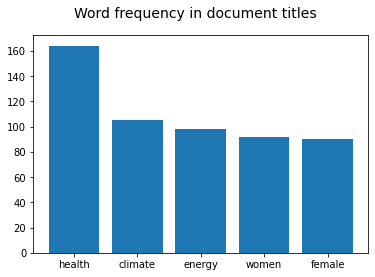

In [11]:
import matplotlib.pyplot as plt

title_words = dict(count_titles.most_common(5))
abstract_words = dict(count_abstract_words.most_common(5))
text_words = dict(count_text_words.most_common(5))

plt.bar(title_words.keys(), title_words.values())
plt.suptitle('Word frequency in document titles', fontsize=14)

Text(0.5, 0.98, 'Word frequency in document abstracts')

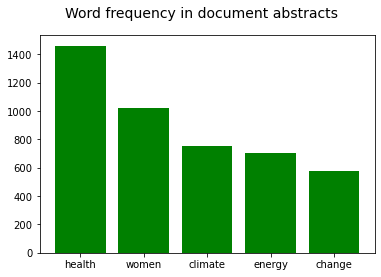

In [12]:
plt.bar(abstract_words.keys(), abstract_words.values(), color= 'green')
plt.suptitle('Word frequency in document abstracts', fontsize=14)

In [13]:
sdg_df = sdg_df[['sdg', 'extracted_title', 'extracted_abstract', 'initial_text']]
sdg_df

,sdg,extracted_title,extracted_abstract,initial_text
0,SDG10,trade liberalization policies aligned renewabl...,paper attempts empirically analyze compatibili...,trade liberalization policies aligned renewabl...
1,SDG10,oil prices macroeconomic factors policies affe...,aim determine nature relationship renewable en...,oil prices macroeconomic factors policies affe...
2,SDG10,energy consumption gdp revisited new panel app...,combines panel techniques wavelet spectral inv...,energy consumption gdp revisited new panel app...
3,SDG10,multiple perspective modeling simulation appro...,environmental issues dependence fossil fuel so...,multiple perspective modeling simulation appro...
4,SDG10,integrating blockchain technology energy secto...,blockchain technology ushering nothing short d...,integrating blockchain technology energy secto...
...,...,...,...,...
884,SDG7,africa sustainable energy goal focus access re...,sustainable development goal sdg focuses ensur...,africa sustainable energy goal focus access re...
885,SDG7,scalingup sustainable renewable energy generat...,three processes urbanization industrialization...,scalingup sustainable renewable energy generat...
886,SDG7,brief review application laser biotechnology e...,abstract bioenergy production biomass sources ...,brief review application laser biotechnology e...
887,SDG7,electric vehicles impacts integration power gr...,exponential rise electricity demand become pri...,electric vehicles impacts integration power gr...


In [14]:
sdg_df.to_csv('sdg_classification_data.csv', encoding='utf-8', index=False)

In [15]:
from sklearn.preprocessing import OneHotEncoder

# splitting in train-validation-test sets in a stratified manner.
from sklearn.model_selection import StratifiedShuffleSplit

In [16]:
# The raw input (Title)
X = sdg_df['extracted_title']
X_val = validation_df['extracted_title']

X.head(10)

0    trade liberalization policies aligned renewabl...
1    oil prices macroeconomic factors policies affe...
2    energy consumption gdp revisited new panel app...
3    multiple perspective modeling simulation appro...
4    integrating blockchain technology energy secto...
5    renewable energy consumption economic growth n...
6    optimal renewable energy supply choices netzer...
7    review recent sizing methodologies hybrid rene...
8    renewable energy consumption industrial produc...
9    governance renewable energy investment mena co...
Name: extracted_title, dtype: object

In [17]:
# The raw output (lyricists)
y = sdg_df['sdg']
y_val = validation_df['sdg']

y.head(10)

0    SDG10
1    SDG10
2    SDG10
3    SDG10
4    SDG10
5    SDG10
6    SDG10
7    SDG10
8    SDG10
9    SDG10
Name: sdg, dtype: object

In [18]:
# We will use this object to split the Train dataset in Train and Validation in a stratified manner.

val_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
val_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)

In [19]:
X_train, X_test, y_train, y_test = None, None, None, None

# getting the indexes for each dataset
for train_index, test_index in val_sss.split(X, y):
    
    print("TRAIN-VAL:", train_index[:10], "TEST:", test_index[:10])
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN-VAL: [235 643 578 605 356 284 587   4  79   1] TEST: [117 257 454 418 396 495   3 724 504  36]
TRAIN-VAL: [576 649  70 549 246 131 712 651 391 497] TEST: [431 823 454 861 168 691 332 658 386  72]
TRAIN-VAL: [551 283  24 235 794 434 594 624 188 835] TEST: [262 641 117 533  10 767 230 462 768 517]
TRAIN-VAL: [292 745 672 740  16 376 398 774 632 457] TEST: [198 720 644 440 293 599 693  22 799 625]
TRAIN-VAL: [ 53 433 231 437 190 762 362 761 169 530] TEST: [545 764 741 109 666 661 712 445 600 167]


In [20]:
# check here the indexes. 
X_train.head()

53     blind spots energy transition policy case stud...
433    wellbeing valuation model method monetizing no...
231    china india lead greening world landuse manage...
437    trajectories quality life following breast can...
190                                soil carbon per mille
Name: extracted_title, dtype: object

In [21]:
y_train.head(10)

53     SDG12
433     SDG3
231    SDG13
437     SDG3
190    SDG13
762     SDG5
362     SDG3
761     SDG5
169    SDG13
530     SDG3
Name: sdg, dtype: object

In [22]:
# We reset the indexes for both the X-train-val and y-train-val in order to break them 
# again into two subsets.
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [23]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()

print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

print()
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (711,)
y_train shape: (711,)

X_val shape: (99,)
y_val shape: (99,)

X_test shape: (178,)
y_test shape: (178,)


In [24]:
# Encoding the labels using a One-Hot Encoder
y_enc = OneHotEncoder(sparse=False)

In [25]:
# At first we run fit_transform on the Training data
y_train_enc = y_enc.fit_transform(y_train.values.reshape(-1, 1))
y_train_enc


array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [26]:
# Then we use the fitted One-hot-Encoder to transform the rest of the data
y_val_enc = y_enc.transform(y_val.values.reshape(-1, 1))

y_test_enc = y_enc.transform(y_test.values.reshape(-1, 1))

In [27]:
print('y_train shape: {}'.format(y_train_enc.shape))
print('y_val shape: {}'.format(y_val_enc.shape))
print('y_test shape: {}'.format(y_test_enc.shape))

y_train shape: (711, 6)
y_val shape: (99, 6)
y_test shape: (178, 6)


In [28]:
# The categories that we obtained by the Encoder
y_enc.categories_

[array(['SDG10', 'SDG12', 'SDG13', 'SDG3', 'SDG5', 'SDG7'], dtype=object)]

In [29]:
# What the aforementioned code did:
temp = pd.DataFrame(y_train_enc)
temp.columns = list(y_enc.categories_[0])
temp.head(10)

,SDG10,SDG12,SDG13,SDG3,SDG5,SDG7
0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0


In [30]:
def highlight_ones(s):
    '''
    highlight the number 1 in a Series yellow.
    '''
    is_max = s == 1
    return ['background-color: yellow' if v else '' for v in is_max]
temp.head(10).style.apply(highlight_ones)

,SDG10,SDG12,SDG13,SDG3,SDG5,SDG7
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
6,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
8,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [31]:
temp.sum(axis=0).head(10)

SDG10     40.0
SDG12     35.0
SDG13    194.0
SDG3     211.0
SDG5     198.0
SDG7      33.0
dtype: float64

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
import pydot

In [33]:
#define max_words parameter
max_words = 250

In [34]:
# Some parameters that we will use:

# Number of Classes for the Y labels (number of lyricists)
nb_classes = len(y_enc.categories_[0])

print('Number of Classes (SDG): {}'.format(nb_classes))

# Number of Epochs that we will train our Feed Forward Network
nb_epoch = 10

# The batch_size of the data that will be fed to the Model when training
batch_size = 64 

# Dropout Rate of the Dropout Layer (how many neurons to shutdown each time)
dropout_rate = 0.2

Number of Classes (SDG): 6


In [35]:
print('Building model...', end='\n\n')

# The model that we will create is a sequential model meaning that
# each layer that we add per line will use as input the output of the 
# former layer added to the model

# define an empty sequential structure 
model = Sequential()

# add a dense layer (MLP)
model.add(Dense(512, input_shape=(max_words,)))

# use a relu activation on MLP's outputs
model.add(Activation('relu'))

# use a dropout layer with with 40% of inputs dropped
model.add(Dropout(dropout_rate))

# add a dense layer (MLP)
model.add(Dense(512))

# use a relu activation on MLP's outputs
model.add(Activation('relu'))

# use a dropout layer with with 20% of inputs droped
model.add(Dropout(dropout_rate))

# add a dense layer (MLP) 
model.add(Dense(nb_classes))

# use a softmax activation on 2nd MLP's outputs
model.add(Activation('softmax'))

# we have defined the structure of the model

# print model layers' info
print(model.summary())

Building model...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               128512    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6

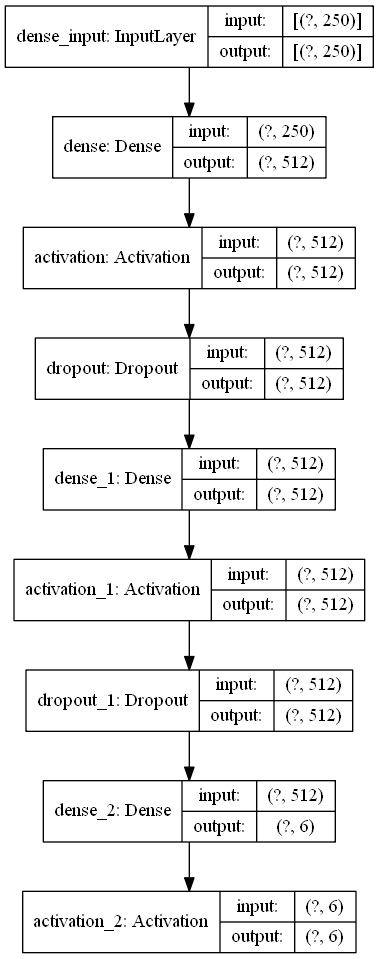

In [36]:
plot_model(model,
           to_file='model_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [37]:
# We compile the model using categorical crossentropy as a loss function 
# The reason is that we want to predict the lyricist among many lyricists

# and Adam as an optimizer (is more robust thatn Gradient Descent Optimizer)
# As a metric we can use "accuracy"
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [39]:
# This vectorizer will give the number of appearances of each word
counter_vectorizer = CountVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    ngram_range=(1, 1), # unigrams
    max_features=max_words,
    binary=False # binary output or full counts. 
)
counter_vectorizer

CountVectorizer(max_features=250, strip_accents='unicode')

In [40]:
X_train_enc = counter_vectorizer.fit_transform(X_train)

In [41]:
X_train_enc

<711x250 sparse matrix of type '<class 'numpy.int64'>'
	with 3285 stored elements in Compressed Sparse Row format>

In [42]:
# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc = counter_vectorizer.transform(X_val)
X_test_enc = counter_vectorizer.transform(X_test)

In [43]:
print('X_train encoded shape: {}'.format(X_train_enc.shape))
print('X_val encoded shape: {}'.format(X_val_enc.shape))
print('X_test encoded shape: {}'.format(X_test_enc.shape))

X_train encoded shape: (711, 250)
X_val encoded shape: (99, 250)
X_test encoded shape: (178, 250)


In [44]:
X_train_enc[0].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int64)

In [45]:
X_train_enc.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [46]:
y_train_enc

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [47]:
X_val_enc.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [48]:
y_val_enc

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0.

In [49]:
# We train (fit our data to) our model
history = model.fit(
    x=X_train_enc.todense(), # features (as dense inputs)
    y=y_train_enc,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=1,               # the most extended verbosity level
    validation_data=(       
    X_test_enc.todense(),     # the validation split that we did before
    y_test_enc)
)

Epoch 1/10
12/12 [==============================] - 0s 33ms/step - loss: 1.4823 - accuracy: 0.5162 - val_loss: 1.1441 - val_accuracy: 0.6685
Epoch 2/10
12/12 [==============================] - 0s 14ms/step - loss: 0.8874 - accuracy: 0.7834 - val_loss: 0.7372 - val_accuracy: 0.7753
Epoch 3/10
12/12 [==============================] - 0s 13ms/step - loss: 0.4928 - accuracy: 0.8622 - val_loss: 0.5460 - val_accuracy: 0.8146
Epoch 4/10
12/12 [==============================] - 0s 13ms/step - loss: 0.3104 - accuracy: 0.9086 - val_loss: 0.4837 - val_accuracy: 0.8427
Epoch 5/10
12/12 [==============================] - 0s 12ms/step - loss: 0.2203 - accuracy: 0.9311 - val_loss: 0.4667 - val_accuracy: 0.8483
Epoch 6/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1568 - accuracy: 0.9620 - val_loss: 0.4770 - val_accuracy: 0.8427
Epoch 7/10
12/12 [==============================] - 0s 15ms/step - loss: 0.1275 - accuracy: 0.9705 - val_loss: 0.4773 - val_accuracy: 0.8371
Epoch 8/10
12

In [50]:
# evaluate and store on score variable on the TEST DATASET
score = model.evaluate(
    X_val_enc.todense(),    # features
    y_val_enc,              # labels
    batch_size=batch_size,   # batch size
    verbose=1                # the most extended verbose
)

2/2 [==============================] - 0s 3ms/step - loss: 0.2457 - accuracy: 0.9192


In [51]:
print(score)

[0.24573726952075958, 0.9191918969154358]


In [52]:
print('\nTest categorical_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test categorical_crossentropy: 0.24573726952075958

Test accuracy: 91.919 %


In [53]:
# Use to yield probability distribution over the categories
y_test_pred_probs = model.predict(X_val_enc) ######
y_test_pred_probs[0]

array([1.5802203e-02, 4.3071667e-03, 1.5412322e-04, 3.1384156e-04,
       3.0975684e-04, 9.7911298e-01], dtype=float32)

In [54]:
y_test_pred_probs.shape

(99, 6)

In [55]:
# y_test_preds = model.predict_classes(X_test_enc)

y_test_preds = np.argmax(model.predict(X_val_enc), axis=-1)

y_test_preds#[:50]

array([5, 0, 0, 0, 0, 0, 5, 5, 1, 0, 2, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 2, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2], dtype=int64)

In [56]:
# custom prediction function 
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)

In [57]:
y_test_pred = get_one_hot_predictions(y_test_pred_probs)
y_test_pred

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0.

In [58]:
# Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
y_test_pred_sdg = y_enc.inverse_transform(y_test_pred).flatten()
y_test_pred_sdg[:20]

array(['SDG7', 'SDG10', 'SDG10', 'SDG10', 'SDG10', 'SDG10', 'SDG7',
       'SDG7', 'SDG12', 'SDG10', 'SDG13', 'SDG12', 'SDG5', 'SDG5', 'SDG5',
       'SDG5', 'SDG5', 'SDG5', 'SDG5', 'SDG5'], dtype=object)

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

In [60]:
print(classification_report(y_true=y_val,
                            y_pred=y_test_pred_sdg))

              precision    recall  f1-score   support

       SDG10       0.83      1.00      0.91         5
       SDG12       1.00      0.33      0.50         6
       SDG13       0.88      0.96      0.92        23
        SDG3       0.94      0.97      0.96        34
        SDG5       1.00      0.93      0.97        30
        SDG7       0.33      1.00      0.50         1

    accuracy                           0.92        99
   macro avg       0.83      0.87      0.79        99
weighted avg       0.94      0.92      0.92        99



In [61]:
import matplotlib.pyplot as plt

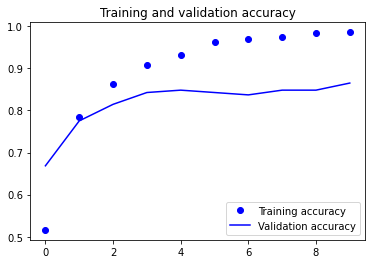

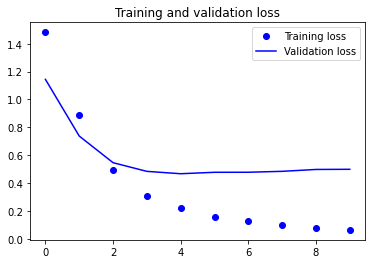

In [62]:
#Let's put your model evaluation into perspective and plot the accuracy and loss plots between training and validation data:

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss =history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [63]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


def plot_multi_class_roc_auc_curves(nb_classes, y_true, y_pred_score, lw: int = 2):
    """
    ROC, AUC for a categorical classifier
    
    ROC curve extends to problems with three or more classes with what is known as the one-vs-all approach.
    For instance, if we have three classes, we will create three ROC curves,

    For each class, we take it as the positive class and group the rest classes jointly as the negative class.

    Class 1 vs classes 2&3
    Class 2 vs classes 1&3
    Class 3 vs classes 1&2

    :param nb_classes:
    :param y_true:
    :param y_pred_score:
    :param lw:
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_score[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_score.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(nb_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--',
             lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.show()

    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.2)
    plt.ylim(0.7, 1)

    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--', lw=lw)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

<ipython-input-63-352507b3f73f>:51: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


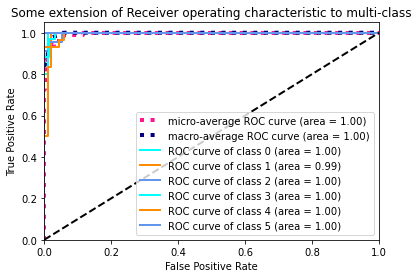

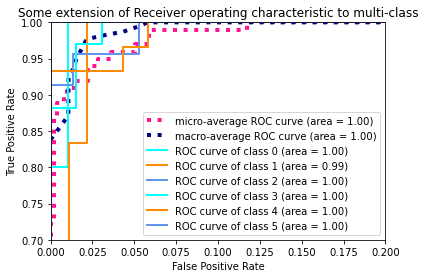

In [64]:
plot_multi_class_roc_auc_curves(nb_classes=6,
                                y_true=y_val_enc,
                                y_pred_score=y_test_pred_probs)

In [65]:
print(confusion_matrix(y_true=y_val, y_pred=y_test_pred_sdg))

[[ 5  0  0  0  0  0]
 [ 1  2  1  0  0  2]
 [ 0  0 22  1  0  0]
 [ 0  0  1 33  0  0]
 [ 0  0  1  1 28  0]
 [ 0  0  0  0  0  1]]


In [66]:
from typing import List, Tuple

def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

In [67]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_test_binarize = lb.fit_transform(y_val_enc)

In [68]:
y_test_transformed = lb.inverse_transform(y_val_enc)
y_test_transformed

array([[0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
 

In [69]:
from sklearn.metrics import confusion_matrix, classification_report

In [70]:
print(classification_report(y_true=y_val,
                            y_pred=y_test_pred_sdg))

              precision    recall  f1-score   support

       SDG10       0.83      1.00      0.91         5
       SDG12       1.00      0.33      0.50         6
       SDG13       0.88      0.96      0.92        23
        SDG3       0.94      0.97      0.96        34
        SDG5       1.00      0.93      0.97        30
        SDG7       0.33      1.00      0.50         1

    accuracy                           0.92        99
   macro avg       0.83      0.87      0.79        99
weighted avg       0.94      0.92      0.92        99



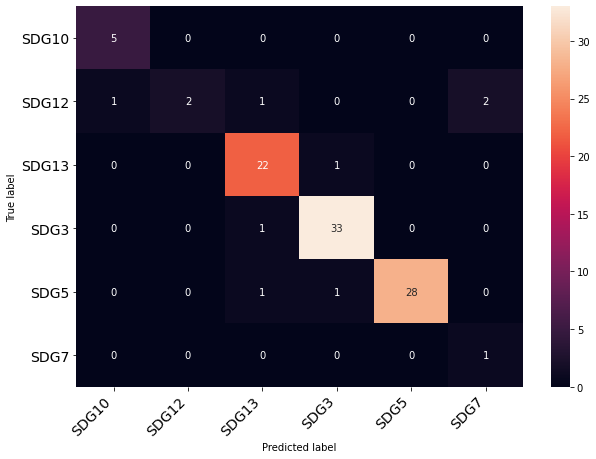

,SDG10,SDG12,SDG13,SDG3,SDG5,SDG7
SDG10,5,0,0,0,0,0
SDG12,1,2,1,0,0,2
SDG13,0,0,22,1,0,0
SDG3,0,0,1,33,0,0
SDG5,0,0,1,1,28,0
SDG7,0,0,0,0,0,1


In [71]:
import seaborn as sns

print_confusion_matrix(y_true=np.argmax(y_test_transformed,axis = 1),
                           y_pred=y_test_preds,
                           class_names=['SDG10', 'SDG12', 'SDG13', 'SDG3', 'SDG5', 'SDG7'])

In [72]:
# Predicting a single title

input_title = """
Protecting the environment via new machine learning techniques
"""

# vectorizing titles with Count Vectorizer
title_vect = counter_vectorizer.transform([input_title])

print(title_vect.shape, end='\n\n')

title_pred = model.predict(title_vect)

print('Probabilities', end='\n\n')
print(title_pred, end='\n\n')

title_pred_hot = get_one_hot_predictions(title_pred)

print('Probabilities One Hot Vector', end='\n\n')
print(title_pred_hot, end='\n\n')

print('SDG Prediction:', end='\n\n')
print(y_enc.inverse_transform(title_pred_hot)[0][0])

(1, 250)

Probabilities

[[0.01630697 0.03721366 0.8322217  0.04080423 0.02990687 0.04354658]]

Probabilities One Hot Vector

[[0. 0. 1. 0. 0. 0.]]

SDG Prediction:

SDG13


In [73]:
import os
import tempfile
import tensorflow as tf

tmpdir = tempfile.mkdtemp()

title_save_path = os.path.join(tmpdir, "MLP_title_model_weights")
tf.saved_model.save(model, title_save_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\arisp\AppData\Local\Temp\tmp2admn5r6\MLP_title_model_weights\assets


In [75]:
loaded = tf.saved_model.load(title_save_path)
print(list(loaded.signatures.keys()))

['serving_default']
